## Spotify's Next Top Model

#### Here we will be hosting a modeling competition that will determine which model deserves to leave this course as Spotify's Next Top Model.


Best of luck to all the contestents! We wish you well, but only the best will rise to the top. There are no participation medals in this game, honey.

In [122]:
# imports  
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from gensim.models.word2vec import Word2Vec, KeyedVectors
import html
import re
import itertools
import csv
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist

sns.set_context('paper')
sns.set_palette('muted',color_codes=True)
sns.set_style('whitegrid')
%matplotlib inline

In [123]:
# Get the data 
df_trk = utils.make_working_df()
df_trk.head()

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,artist_followers,artist_genre,...,pl_mean_trkpop,pl_std_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_std_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,76.0,None,...,1.333333,1.505545,0.0,6.0,1.764706,1.888432,13,trash_factory,515,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,76.0,None,...,1.333333,1.505545,0.0,6.0,1.764706,1.888432,13,trash_factory,515,0
2,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0,103793.0,[polynesian pop],...,38.269231,22.298982,0.0,58.0,38.419355,17.651769,20,star,166,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,122496.0,[hardstyle],...,15.510000,15.835962,0.0,47.0,11.272727,16.736563,18,trash_factory,166,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,1281.0,None,...,0.000000,0.000000,0.0,0.0,0.000000,NaN,1,garage_band,1731,0


In [124]:
# Drop these columns because we dont need them for anything in modeling or EDA
df_trk = df_trk.drop(['pl_desc','pl_name','celeb_name'],axis=1)

In [125]:
df_trk.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers',
       'artist_genre', 'artist_id', 'artist_pop', 'collab', 'pl_followers',
       'pl_num_trks', 'pl_owner', 'cluster', 'cluster_norm', 'is_celeb',
       'user_followers', 'pl_first_date', 'pl_last_date', 'pl_days_active',
       'pl_days_old', 'pl_num_trk', 'pl_num_art', 'pl_min_trkpop',
       'pl_max_trkpop', 'pl_mean_trkpop', 'pl_std_trkpop', 'art_min_trkpop',
       'art_max_trkpop', 'art_mean_trkpop', 'art_std_trkpop', 'art_total_trks',
       'art_class', 'user_pls_in_sample', 'pl_desc_chars'],
      dtype='object')

## EDA:

We explore the data (and our engineered features) at both the track and the playlist level.  As we can see below, we have about 9.7 playlists per user when we include all users. Below, when we drop playlists with below 1 follower, we have about 4.4 playlists per user.  Likewise, we start with ~368k tracks and after we drop the playlists with fewer than 1 follower we only have ~211k tracks remaining.

In [126]:
print('We have {} unique spotify playlist owners.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists.'.format(len(df_trk['pl_id'].unique())))

We have 846 unique spotify playlist owners.
We have 8183 unique spotify playlists.


In [127]:
# Make a playlist data subset as we'll use this often for EDA.  

df_pl_columns = ['pl_id', 'pl_days_old', 
                 'pl_days_active', 'pl_num_trk', 'pl_num_art', 
                 'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 
                 'pl_followers', 'pl_num_trks','pl_desc_chars'] 

df_pl = df_trk.groupby('pl_id').first().reset_index()[df_pl_columns]

In [128]:
print("Master DF has total of {0} rows/tracks (including zero followers)".format(df_trk.shape[0]))

# Cut out the zero- and one- follower playlists
# Cutting one-follower playlists because it's likely just an individual following their own list
df_trk = df_trk[df_trk['pl_followers'] > 1]
print("Master DF has total of {0} rows/tracks (after removing zero followers) \n".format(df_trk.shape[0]))

Master DF has total of 367911 rows/tracks (including zero followers)
Master DF has total of 210798 rows/tracks (after removing zero followers) 



In [129]:
print('We have {} unique spotify users who own a playlist with > 1 follower.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists with > 1 follower.'.format(len(df_trk['pl_id'].unique())))

We have 779 unique spotify users who own a playlist with > 1 follower.
We have 3422 unique spotify playlists with > 1 follower.


#### Playlist followers:
Engineering   more   features   around   artist and   playlist   data   yielded   interesting relationships.   A   cursory   measure   of   playlist success,   our   generalized   project   goal,   is the   number   of   followers   per   playlist.   The histograms   to   the   right   show   a   significant right-skew,   with   most   playlists   having   few followers   and   a   few   approaching   the   1M mark.   The   log-transform   of   followers illustrates   a   potentially   more   useful response   variable.

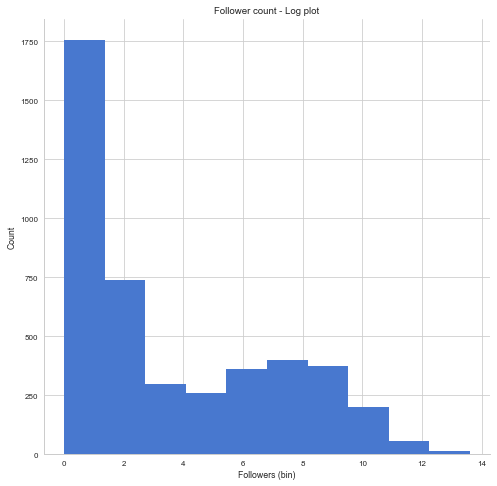

In [130]:
# Plot histogram of follower counts for each playlist
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(np.log(df_pl[df_pl['pl_followers']>0].pl_followers))
ax.set_title("Follower count - Log plot")
ax.set_xlabel("Followers (bin)")
ax.set_ylabel("Count")
sns.despine()

##### Artist analysis:

We   separated   artists   into   five   distinct   categories   using   combinations   of   their   mean   popularity   and   total   number   of   tracks   as follows:    superstar ,     star ,     one_hit_wonder ,   garage_band ,    and     trash_factory .
These   categories   should   be   self-descriptive,   but   the   two   plots   below   do   a   fantastic   job   of   illustrating   each   in   terms   of   their thresholds   and   relationships.      The   artist   popularity   metric   ties   out   with   our   expectations   because   we   see   people   like   Post Malone,   Camila   Cabello,   and   Ed   Sheeran   in   our   superstar   category.

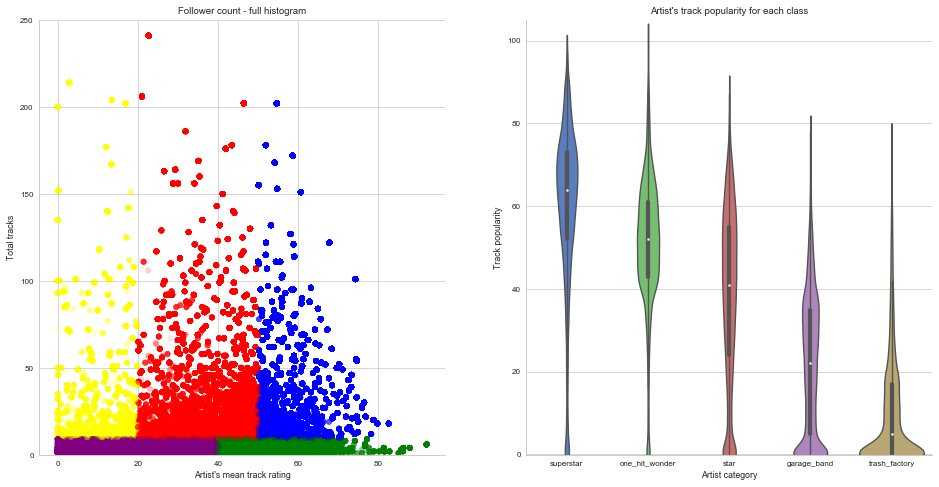

In [131]:
# Plot follower count vs. average track popularity
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))

colors = {'superstar':'blue', 'star':'red', 'trash_factory':'yellow', 'one_hit_wonder':'green', 'garage_band':'purple'}

ax1.scatter(df_trk.art_mean_trkpop, df_trk.art_total_trks, alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax1.set_title("Follower count - full histogram")
ax1.set_xlabel("Artist's mean track rating")
ax1.set_ylabel("Total tracks")
ax1.set_ylim((0,250))

order = ['superstar','one_hit_wonder','star','garage_band','trash_factory']

sns.violinplot(data=df_trk, y='trk_popularity',x='art_class',order=order,ax=ax2)
ax2.set_title("Artist's track popularity for each class")
ax2.set_xlabel("Artist category")
ax2.set_ylabel("Track popularity")
ax2.set_ylim((-0.1, 105))

sns.despine(top = True, right = True)

#### Continuing Artist Analysis:
Comparing   these   five   artist   categories   with   specific   track popularities   (as   determined   by   Spotify)   and   those   tracks’ playlists’   followers   shows   us   that   not   only   do   most   playlists incorporate   popular   artists   (red/blue),   but   a   lot   of   them   have the   “superstar”   artists’   best   songs   (the   mostly   blue   right   side),   as well   as   a   smattering   of   “one-hit-wonders”   (red   in   the   middle) and   a   dense   area   of   moderately   popular   songs   throughout (between   30   and   70   popularity).   This   relationship   and   playlist architecture   should   also   be   intuitive,   and   the   scatterplot   below   illustrates   it   well.

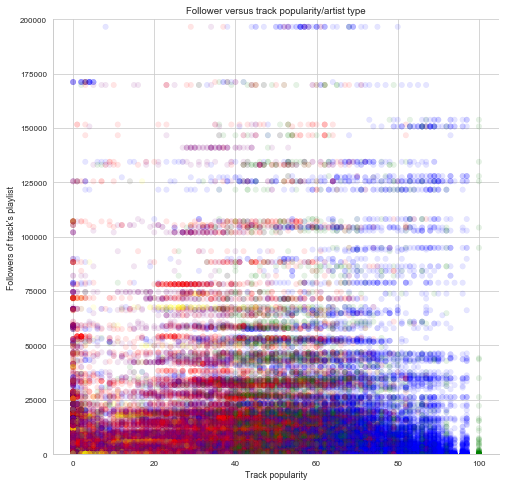

In [132]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(figsize = (8,8))

colors = {'superstar':'blue', 'star':'red', 'trash_factory':'yellow', 'one_hit_wonder':'green', 'garage_band':'purple'}

ax.scatter(df_trk['trk_popularity'], df_trk['pl_followers'], alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower versus track popularity/artist type")
ax.set_xlabel("Track popularity")
ax.set_ylabel("Followers of track's playlist")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

##### Time and playlists
It   appears   that   there   may   be   a   relationship   between   the   number of   tracks   a   playlist   has   and   its   number   of   followers   (top-left),   as well   as   length   of   its   description (top-right).  We   also   investigated   the   impact   of   playlist   turnover   rate,   or   relative   age, days   between   the   oldest   and   newest   track   being added (bottom-left),   as   well   as   the  age of the oldest song   on   playlist   follower   count   (bottom-right).

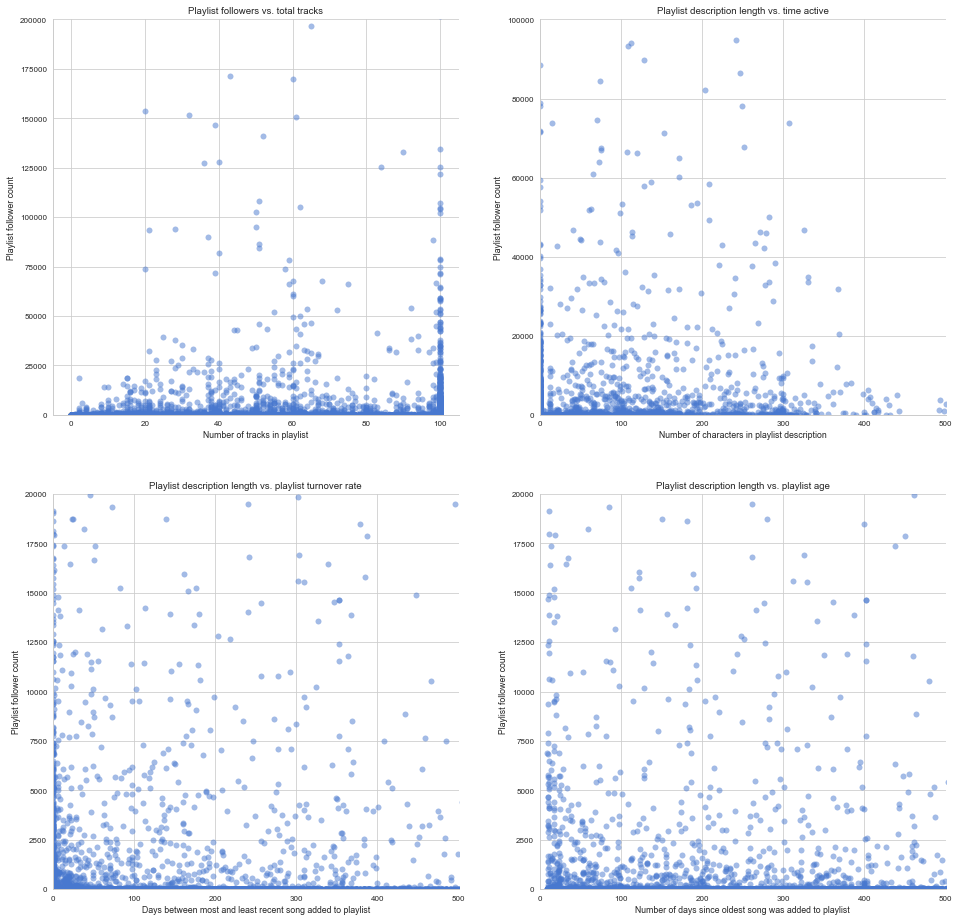

In [133]:
# Test if bigger playlists have more followers
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize = (16,16))
ax1.scatter(df_pl.pl_num_trk, df_pl.pl_followers, alpha = 0.5)
ax1.set_title("Playlist followers vs. total tracks")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Playlist follower count")
ax1.set_ylim((0,200000))

ax2.scatter(df_pl.pl_desc_chars, df_pl.pl_followers, alpha = 0.5)
ax2.set_title("Playlist description length vs. time active")
ax2.set_xlabel("Number of characters in playlist description")
ax2.set_ylabel("Playlist follower count")
ax2.set_ylim((0,100000))
ax2.set_xlim((0,500))

ax3.scatter(df_pl.pl_days_active, df_pl.pl_followers, alpha = 0.5)
ax3.set_title("Playlist description length vs. playlist turnover rate")
ax3.set_xlabel("Days between most and least recent song added to playlist")
ax3.set_ylabel("Playlist follower count")
ax3.set_ylim((0,20000))
ax3.set_xlim((0,500))

ax4.scatter(df_pl.pl_days_old, df_pl.pl_followers, alpha = 0.5)
ax4.set_title("Playlist description length vs. playlist age")
ax4.set_xlabel("Number of days since oldest song was added to playlist")
ax4.set_ylabel("Playlist follower count")
ax4.set_ylim((0,20000))
ax4.set_xlim((0,500))

sns.despine(top = True, right = True)

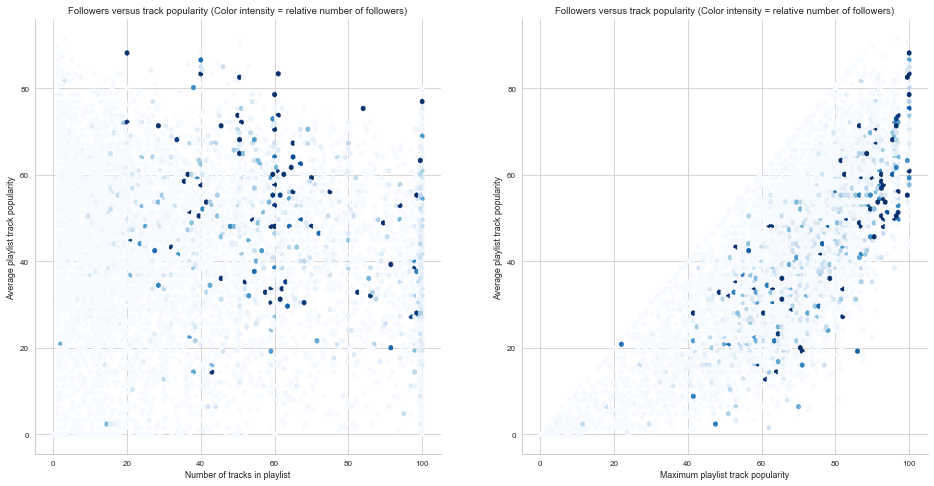

In [134]:
# Test playlist mean/max popularity versus follower count
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))
ax1.hexbin(df_pl.pl_num_trk, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=35000)
ax1.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Average playlist track popularity")

ax2.hexbin(df_pl.pl_max_trkpop, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=25000)
ax2.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax2.set_xlabel("Maximum playlist track popularity")
ax2.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

In [135]:
len(df_trk)

210798

In [136]:
# Blow out the dataframe by genre
df_trk['artist_genre'] = [g if type(g)==list else [] for g in df_trk['artist_genre']]
bigdf = utils.explode_value(df_trk[['artist_genre','pl_followers','artist_pop']],'artist_genre')

In [137]:
len(df_trk)

210798

In [138]:
genres_by_artist_pop = bigdf[['artist_genre','artist_pop']].groupby('artist_genre',as_index=False\
                                                    ).mean().sort_values('artist_pop',ascending=False).head(15)
genres_by_pl_followers = bigdf[['artist_genre','pl_followers']].groupby('artist_genre',as_index=False\
                                                    ).median().sort_values('pl_followers',ascending=False).head(15)

##### Genres: 

Here we see some of the genres that show up in the most popular playlists by followers.  The barplot directly below is by the median number of playlist followers, so as to be less sensitive to outliers.  The barplot below this one is based on mean artist popularity by genre. As we can see, there are some specific genres at the top that we would usually associate with one artist (canadian pop - Justin Bieber, detroit hip hop - Eminem). It is likely those artists are skewing the distribution, since those are their respective genres. Sadly, we do not have enough members of each genre to get a good view of the most popular genres by artist.

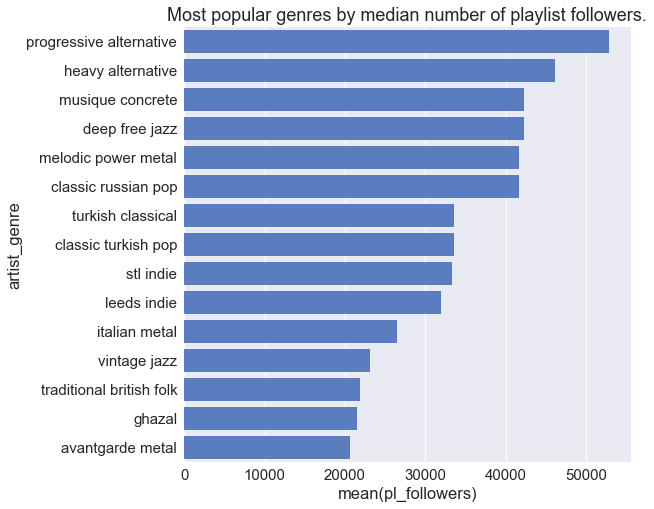

In [139]:
sns.set(font_scale=1.5)
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_pl_followers,y='artist_genre',x='pl_followers',color='b',ax=ax)
plt.title('Most popular genres by median number of playlist followers.')

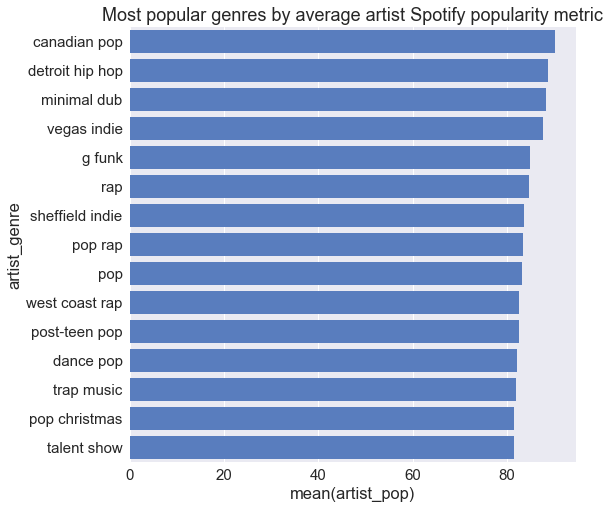

In [140]:
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_artist_pop,y='artist_genre',x='artist_pop',color='b',ax=ax)
plt.title('Most popular genres by average artist Spotify popularity metric')

## Merge in the genre features:

We are waiting until now to merge in the genre features to save memory in the above exercises.

In [141]:
# Merge in the genre features
df_full = utils.join_genre_features(df_trk)
df_full = df_full.drop('artist_genre',axis=1)
assert(len(df_trk)==len(df_full))

##### Playlist level genres:

Below we look at the most common genre by number of playlist occurances.  Here we use the "mode genre" field.  This field is made by looking at all the genres that make up a playlist (on a track level) and choosing the most common (mode).

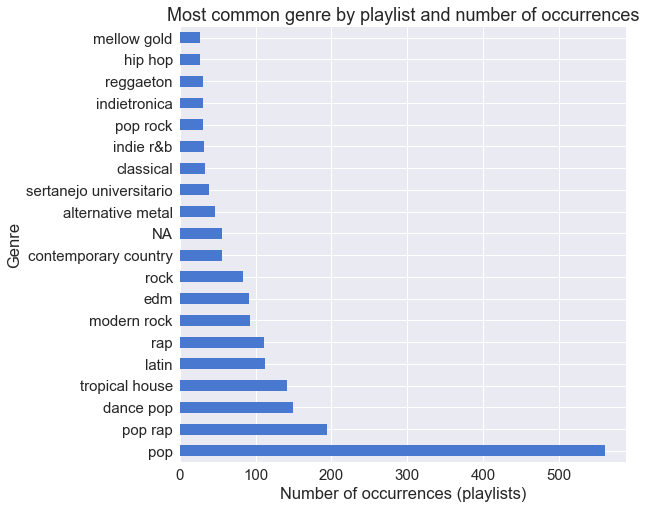

In [142]:
fig, ax = plt.subplots(figsize=(8,8))

df_full[['pl_id','mode_genre']].drop_duplicates()['mode_genre'].value_counts()[:20].plot(kind='barh',color='b',ax=ax)
ax.set_title('Most common genre by playlist and number of occurrences')
ax.set_xlabel('Number of occurrences (playlists)')
ax.set_ylabel('Genre')

### Track level genres:

Here we take a quick look at some genre-type information.  By genre type we mean, we are looking at any sub-genres that fall in a larger, more general genre.  For example, 'classic rock', 'heavy rock', and 'swedish electronic pop rock' would all fall in our 'rock' genre-type.  For each genre related to a song we have binary variables to indicate whether that genre-type is present in the track.  The genre types below represent the 15 most common genres in our dataset. 

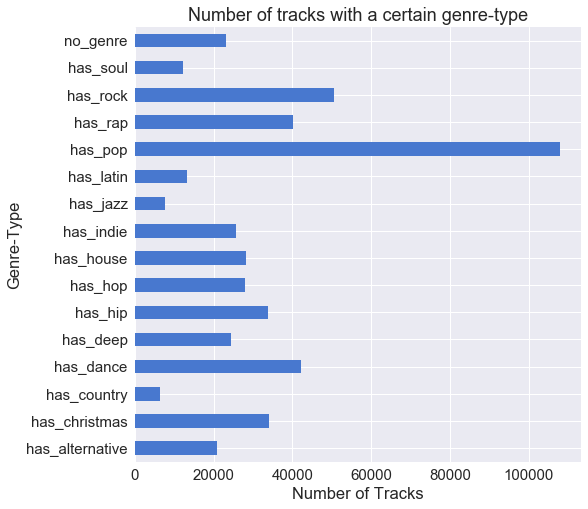

In [143]:
fig,ax = plt.subplots(figsize=(8,8))

mc_genres = ['has_alternative', 'has_christmas', 'has_country', 'has_dance',
       'has_deep', 'has_hip', 'has_hop', 'has_house', 'has_indie', 'has_jazz',
       'has_latin', 'has_pop', 'has_rap', 'has_rock', 'has_soul','no_genre']
df_full[mc_genres].sum(axis=0).plot(kind='barh',color='b',ax=ax)
ax.set_title('Number of tracks with a certain genre-type')
ax.set_ylabel('Genre-Type')
ax.set_xlabel('Number of Tracks')

### Celebrity playlist owners:

One more important factor we'd like to control is whether the owner of the playlist is a known celebrity.  The motivation for this is that some of the most popular playlists we've seen have been from a celebrity's official spotify account.  We'd like to be able to account for this bias.

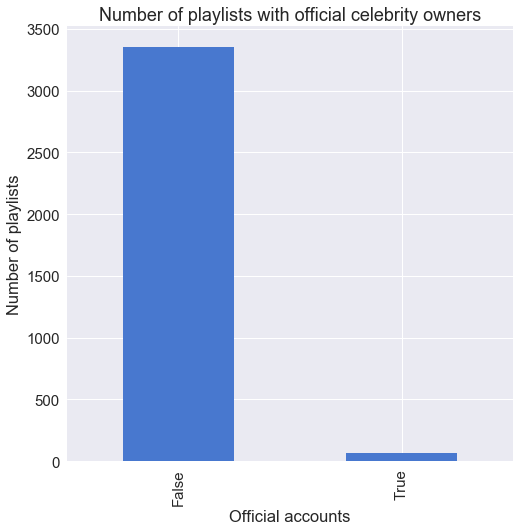

In [144]:
# Add new feature 'pl_official' if the play is owned by an account with the word 'official' in it
df_full['is_official'] = df_full.pl_owner.str.contains('official') == 1

# Plot the number of official and unoffical playlists
fig,ax = plt.subplots(figsize=(8,8))

df_full.groupby(['is_official'])['pl_id'].nunique().plot(kind='bar',color='b',ax=ax)
ax.set_title('Number of playlists with official celebrity owners')
ax.set_ylabel('Number of playlists')
ax.set_xlabel('Official accounts')

## Now to the modeling!!

First, lets manicure some training / test data.  Again, here we are just going to use the playlists (and realted tracks) that have more than one follower.  The rational behind this is that we don't want to use data that could skew our popularity metrics for tracks if it is unikely that those users have any followers that could potentially follow their playlist. Essentially, we do not think those users have enough presence on Spotify for number of followers to be a meaningful feedback metric for playlist success.

In [146]:
df_full.dtypes

trk_added_at          datetime64[ns]
art_name                      object
trk_duration                 float64
explicit                     float64
trk_id                        object
trk_name                      object
pl_id                         object
trk_popularity               float64
artist_followers             float64
artist_id                     object
artist_pop                   float64
collab                          bool
pl_followers                   int32
pl_num_trks                    int64
pl_owner                      object
cluster                      float64
cluster_norm                 float64
is_celeb                        bool
user_followers               float64
pl_first_date         datetime64[ns]
pl_last_date          datetime64[ns]
pl_days_active               float64
pl_days_old                  float64
pl_num_trk                     int64
pl_num_art                     int64
pl_min_trkpop                float64
pl_max_trkpop                float64
p

In [147]:
# We can drop all of our id's (except for pl_id) and text we will not OH encode.
data = df_full.drop(['pl_owner','collab','trk_name','artist_id','art_name','trk_added_at'],axis=1)
print('We have {} rows.'.format(len(df_full)))
print('We have {} columns.'.format(len(data.columns)))

We have 210798 rows.
We have 49 columns.


In [148]:
data = pd.get_dummies(data=data,prefix=[''],columns=['art_class'])
dcols = ['cluster','trk_id','pl_min_trkpop','pl_max_trkpop','pl_mean_trkpop','art_min_trkpop','art_max_trkpop', \
         'art_mean_trkpop','art_total_trks','user_pls_in_sample']
datat = data.drop(dcols, axis=1)

mapping = {'trk_duration': {'total_duration': 'sum', 'avg_duration': 'mean'}, \
           'explicit': {'number_explicit': 'sum'}, \
           'trk_popularity': {'trk_pop_mean': 'mean', 'trk_pop_max': 'max','trk_pop_min': 'min'}, \
           'artist_followers': {'art_f_mean': 'mean', 'art_f_max': 'max', 'art_f_min': 'min'}, \
           'artist_pop': {'art_pop_mean': 'mean', 'art_pop_max': 'max','art_pop_min': 'min'}, \
           'pl_followers': {'pl_followers': 'first'}, \
           'pl_num_trk': {'pl_num_trk': 'first'}, \
           'cluster_norm': {'cluster_norm': 'first'},
           'is_celeb': {'total_celebs': 'sum'}, \
           'is_official': {'is_official': 'first'}, \
           'user_followers': {'user_f_mean': 'mean', 'user_f_max': 'max', 'user_f_min': 'min'}, \
           'pl_first_date': {'pl_first_date': 'first'}, \
           'pl_last_date': {'pl_last_date': 'first'}, \
           'pl_days_active': {'pl_days_active': 'first'}, \
           'pl_days_old': {'pl_days_old': 'first'}, \
           'pl_num_art': {'pl_num_art': 'first'}, \
           'pl_desc_chars': {'pl_desc_chars': 'first'}, \
           '_superstar': {'num_superstar': 'sum'}, '_star': {'num_star': 'sum'}, \
           '_trash_factory': {'num_trash_factory': 'sum'}, '_one_hit_wonder': {'num_one_hit_wonder': 'sum'}, \
           '_garage_band': {'num_garage_band': 'sum'},
           'has_alternative': {'num_alternative': 'sum'}, 'has_christmas': {'num_christmas': 'sum'}, \
           'has_country': {'num_country': 'sum'}, 'has_dance': {'num_dance': 'sum'}, \
           'has_deep': {'num_deep': 'sum'}, 'has_hip': {'num_hip': 'sum'}, \
           'has_hop': {'num_hop': 'sum'}, 'has_house': {'num_house': 'sum'}, \
           'has_indie': {'num_indie': 'sum'}, 'has_jazz': {'num_jazz': 'sum'}, \
           'has_latin': {'num_latin': 'sum'}, 'has_pop': {'num_pop': 'sum'}, \
           'has_rap': {'num_rap': 'sum'}, 'has_rock': {'num_rock': 'sum'}, \
           'has_soul': {'num_soul': 'sum'}, 'no_genre': {'num_no_genre': 'sum'}, \
           'mode_genre': {'mode_genre': 'first'} }


agg_data = datat.groupby('pl_id',as_index=False).agg(mapping)
agg_data.columns = agg_data.columns.droplevel(0)
agg_data = agg_data.rename(columns={'':'pl_id'})

C:\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## We have to aggregate to the plist level

In [149]:
# Clean the dates to get just year
agg_data['pl_first_date'] = agg_data['pl_first_date'].map(lambda x: x.year)
agg_data['pl_last_date'] = agg_data['pl_last_date'].map(lambda x: x.year)

# Median imputation for 191 missing dates
agg_data['pl_first_date'] = agg_data['pl_first_date'].fillna(agg_data['pl_first_date'].median())
agg_data['pl_last_date'] = agg_data['pl_last_date'].fillna(agg_data['pl_last_date'].median())

In [150]:
# Impute median values for columns with missing values
cols_to_impute = ['user_f_mean','user_f_max','user_f_min','pl_days_old','pl_days_active','art_pop_min', \
                 'art_pop_max','art_pop_mean','art_f_min','art_f_max','art_f_mean']
for c in cols_to_impute:
    agg_data[c] = agg_data[c].fillna(agg_data[c].median())
    
# We have no null values after imputation!
print('It is',agg_data.isnull().sum().sum(axis=0)==0,'that we have no null values.')

It is True that we have no null values.


In [151]:
# OH Encode 'mode_genre', 'pl_first_date', 'pl_last_date', 'cluster_norm'
oh_agg_data = pd.get_dummies(agg_data,prefix=['mode_genre','pl_first_date', 'pl_last_date', 'cluster_norm'],\
                                columns=['mode_genre','pl_first_date', 'pl_last_date', 'cluster_norm'])


In [152]:
# How many cols?
print('We now have {} columns'.format(len(oh_agg_data.columns)))

# Split into train and test 75% / 25% split
plists = oh_agg_data['pl_id'].unique()
msk = np.random.rand(len(plists)) < 0.75
train_plists = plists[msk]
test_plists = plists[~msk]

# Actually seperate the data (keeping playlists together)
train = oh_agg_data[oh_agg_data['pl_id'].isin(train_plists)]
test = oh_agg_data[oh_agg_data['pl_id'].isin(test_plists)]

# Did everything go well?
print('It is',len(train)+len(test)==len(oh_agg_data),'that everything went well.')

We now have 481 columns
It is True that everything went well.


In [153]:
# Standardize
# It is valid to ignore chained assignment warning here because we have no intention of modifying the data
# table, which is what thew chained assignment warning is letting us know.
pd.set_option('chained_assignment',None)

# Do the math
numeric_cols = ['total_duration', 'avg_duration', 'number_explicit', 'trk_pop_mean', 'trk_pop_max', \
                'trk_pop_min', 'art_f_mean', 'art_f_max', 'art_f_min', 'art_pop_mean', 'art_pop_max', \
                'art_pop_min', 'pl_followers', 'pl_num_trk', 'total_celebs', 'user_f_mean', 'user_f_max', \
                'user_f_min','pl_days_active', 'pl_days_old', 'pl_num_art', 'pl_desc_chars', 'num_superstar', \
                'num_star', 'num_trash_factory', 'num_one_hit_wonder', 'num_garage_band', 'num_alternative', \
                'num_christmas', 'num_country', 'num_dance', 'num_deep', 'num_hip', 'num_hop', 'num_house', \
                'num_indie', 'num_jazz', 'num_latin', 'num_pop', 'num_rap', 'num_rock', 'num_soul', \
                'num_no_genre']

for nc in numeric_cols:
    train.loc[:,nc] = (train[nc].values-train[nc].mean(axis=0))/train[nc].std(axis=0)
    test.loc[:,nc] = (test[nc].values-test[nc].mean(axis=0))/test[nc].std(axis=0)

In [154]:
# X / y split
x_train = train.drop(['pl_followers','pl_id'],axis=1)
y_train = train['pl_followers']
x_test = test.drop(['pl_followers','pl_id'],axis=1)
y_test = test['pl_followers']

#### Lets find some meaningful features

In [135]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


In [98]:
# Global CV params for GLM models
reg_par = [1e-3,1e-2,1e-1,1.0,1e2,1e3,1e4,1e5]
l1_ratio = [.25,.5,.75]

In [99]:
# Linear Regression
lr = LinearRegression().fit(x_train,y_train)

In [100]:
# Ridge Regression
ridge = LassoCV(alphas=reg_par,cv=5).fit(x_train,y_train)

In [101]:
# Lasso Regression
lasso = LassoCV(alphas=reg_par,cv=5).fit(x_train,y_train)

In [102]:
# Elastic Net Regression
en = ElasticNetCV(l1_ratio=l1_ratio,alphas=reg_par,cv=5).fit(x_train,y_train)

In [121]:
# k-NN Regression
ks = {'n_neighbors': [4,20,50]}
gridknn = GridSearchCV(KNeighborsRegressor(),cv=5,param_grid=ks).fit(x_train,y_train)


In [145]:
best_k_knn = gridknn.best_params_['n_neighbors']
print('The best k was:',best_k_knn)

The best k was: 50


In [124]:
knn = KNeighborsRegressor(n_neighbors=best_k_knn).fit(x_train,y_train)

In [110]:
# Random Forest Regression
trees = {'n_estimators': [25,50,100,200,300,500]}
gridrf = GridSearchCV(RandomForestRegressor(max_features='sqrt'),cv=5,param_grid=trees).fit(x_train,y_train)


In [148]:
best_trees_rf = gridrf.best_params_['n_estimators']
print('The best number of trees for Random Forest was:',best_trees_rf)

The best number of trees for Random Forest was: 200


In [130]:
rf = RandomForestRegressor(max_features='sqrt',n_estimators=best_trees_rf).fit(x_train,y_train)

In [149]:
# AdaBoost Regression
trees_lr = {'n_estimators': [15,25,50,100], 'base_estimator': [DecisionTreeRegressor(max_depth=3), \
                                                                DecisionTreeRegressor(max_depth=4),\
                                                                DecisionTreeRegressor(max_depth=5)]}
gridab = GridSearchCV(AdaBoostRegressor(learning_rate=.1),cv=5,param_grid=trees_lr).fit(x_train,y_train)

In [150]:
print('The best number of trees was: ',gridab.best_params_['n_estimators'])

The best numnber of trees was:  25


In [151]:
ab = AdaBoostRegressor(learning_rate=0.1,**gridab.best_params_).fit(x_train,y_train)

In [153]:
# SVM Regression
svr_par = {'C': [1e-1,1.0,1e2,1e3,1e4]}
gridsvr = GridSearchCV(SVR(),cv=5,param_grid=svr_par).fit(x_train,y_train)

In [154]:
svm = SVR(**gridsvr.best_params_).fit(x_train,y_train)

In [155]:
# Results!
print('Linear Regression R^2 on train:',lr.score(x_train,y_train))
print('Linear Regression R^2 on test:',lr.score(x_test,y_test))

print('Ridge Regression R^2 on train:',ridge.score(x_train,y_train))
print('Ridge Regression R^2 on test:',ridge.score(x_test,y_test))

print('Lasso Regression R^2 on train:',lasso.score(x_train,y_train))
print('Lasso Regression R^2 on test:',lasso.score(x_test,y_test))

print('Elastic Net Regression R^2 on train:',en.score(x_train,y_train))
print('Elastic Net Regression R^2 on test:',en.score(x_test,y_test))

print('k-NN Regression R^2 on train:',knn.score(x_train,y_train))
print('k-NN Regression R^2 on test:',knn.score(x_test,y_test))

print('Random Forest Regression R^2 on train:',rf.score(x_train,y_train))
print('Random Forest Regression R^2 on test:',rf.score(x_test,y_test))

print('AdaBoost Regression R^2 on train:',ab.score(x_train,y_train))
print('AdaBoost Regression R^2 on test:',ab.score(x_test,y_test))

print('SVM Regression R^2 on train:',svm.score(x_train,y_train))
print('SVM Regression R^2 on test:',svm.score(x_test,y_test))

Linear Regression R^2 on train: 0.111119658092
Linear Regression R^2 on test: -5.85988830046e+18
Ridge Regression R^2 on train: 0.0677511626041
Ridge Regression R^2 on test: 0.105548506764
Lasso Regression R^2 on train: 0.0677511626041
Lasso Regression R^2 on test: 0.105548506764
Elastic Net Regression R^2 on train: 0.0559048139025
Elastic Net Regression R^2 on test: 0.0965700611982
k-NN Regression R^2 on train: 0.105503007763
k-NN Regression R^2 on test: 0.0784198197748
Random Forest Regression R^2 on train: 0.89698597515
Random Forest Regression R^2 on test: 0.102154440632
AdaBoost Regression R^2 on train: 0.78999177477
AdaBoost Regression R^2 on test: 0.057829528987
SVM Regression R^2 on train: 0.141921194824
SVM Regression R^2 on test: 0.141142064842


### We have a tentative Spotify's next top model.  SVM is out in front, but wait until the final episode 12/5 at 7:00am with Ryan Janssen to see how this one ends! 